In [2]:
import pandas as pd

df = pd.read_csv('/content/data.csv', encoding='latin1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Preprocessing**

In [4]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [5]:
data_types = df.dtypes
print(data_types)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [6]:
# Check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df = df.dropna(subset=['CustomerID'])

In [8]:
# Check for missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

<ipython-input-9-1f26bb90d392>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


## **RFM Calculation**

In [10]:
import pandas as pd

# Assuming your DataFrame is named 'df'

# Calculate Recency (R)
reference_date = df['InvoiceDate'].max()  # Use the latest invoice date as the reference date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
recency_df = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df['Recency'] = (reference_date - recency_df['InvoiceDate']).dt.days

# Calculate Frequency (F)
frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

# Calculate Monetary (M)
df['Monetary'] = df['Quantity'] * df['UnitPrice']
monetary_df = df.groupby('CustomerID')['Monetary'].sum().reset_index()

# Merge the RFM metrics into a single DataFrame
rfm_df = recency_df[['CustomerID', 'Recency']].merge(frequency_df, on='CustomerID', how='left')
rfm_df = rfm_df.merge(monetary_df, on='CustomerID', how='left')

# Display the RFM metrics for each customer
print(rfm_df)


<ipython-input-10-868873adeafc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
<ipython-input-10-868873adeafc>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Monetary'] = df['Quantity'] * df['UnitPrice']


      CustomerID  Recency  Frequency  Monetary
0        12346.0      325          2      0.00
1        12347.0        1          7   4310.00
2        12348.0       74          4   1797.24
3        12349.0       18          1   1757.55
4        12350.0      309          1    334.40
...          ...      ...        ...       ...
4367     18280.0      277          1    180.60
4368     18281.0      180          1     80.82
4369     18282.0        7          3    176.60
4370     18283.0        3         16   2094.88
4371     18287.0       42          3   1837.28

[4372 rows x 4 columns]


### **RFM Segmentation**

In [11]:
import pandas as pd

# Assuming your DataFrame is named 'rfm_df' and contains Recency, Frequency, and Monetary metrics

# Define quartiles for each RFM metric
quartiles = rfm_df[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.5, 0.75])

# Define custom scores (e.g., 1 to 5) for each RFM metric
custom_scores = {
    'Recency_Score': [5, 4, 3, 2, 1],       # Higher score for more recent customers
    'Frequency_Score': [1, 2, 3, 4, 5],     # Higher score for more frequent customers
    'Monetary_Score': [1, 2, 3, 4, 5]      # Higher score for customers with higher monetary value
}

# Assign quartile-based or custom-defined scores for each RFM metric
rfm_df['Recency_Score'] = pd.qcut(rfm_df['Recency'], q=4, labels=False, duplicates='drop') + 1  # Quartiles or custom-defined bins
rfm_df['Frequency_Score'] = pd.qcut(rfm_df['Frequency'], q=4, labels=False, duplicates='drop') + 1
rfm_df['Monetary_Score'] = pd.qcut(rfm_df['Monetary'], q=4, labels=False, duplicates='drop') + 1

# Combine the RFM scores to create a single RFM score
rfm_df['RFM_Score'] = rfm_df['Recency_Score'] + rfm_df['Frequency_Score'] + rfm_df['Monetary_Score']

# Display the RFM scores for each customer
print(rfm_df[['CustomerID', 'Recency_Score', 'Frequency_Score', 'Monetary_Score', 'RFM_Score']])


      CustomerID  Recency_Score  Frequency_Score  Monetary_Score  RFM_Score
0        12346.0              4                1               1          6
1        12347.0              1                3               4          8
2        12348.0              3                2               4          9
3        12349.0              2                1               4          7
4        12350.0              4                1               2          7
...          ...            ...              ...             ...        ...
4367     18280.0              4                1               1          6
4368     18281.0              4                1               1          6
4369     18282.0              1                1               1          3
4370     18283.0              1                3               4          8
4371     18287.0              2                1               4          7

[4372 rows x 5 columns]


## **Customer Segmentation**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

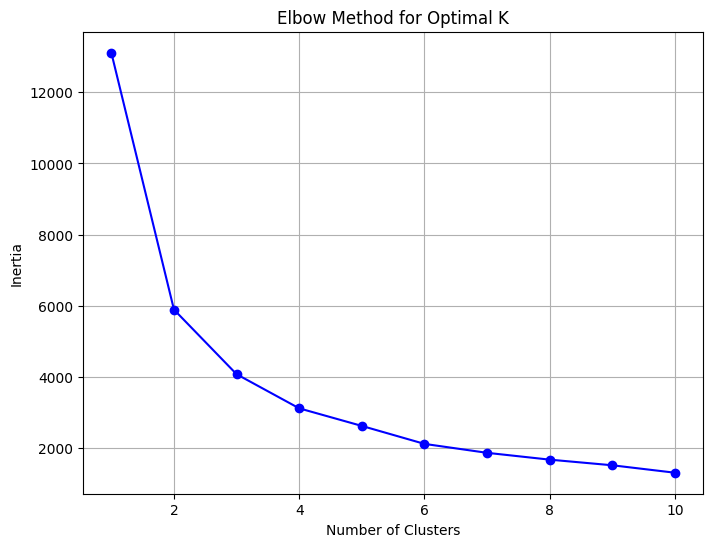

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your RFM data
# Assuming rfm_df contains RFM scores for each customer

# Scaling the data (if needed)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency_Score', 'Frequency_Score', 'Monetary_Score']])

# Finding the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

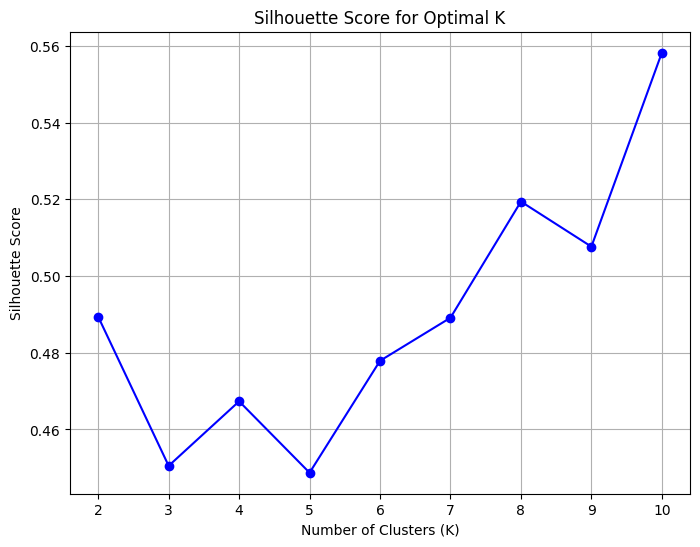

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [ ]:
# Apply K-Means clustering with the chosen K
kmeans = KMeans(n_clusters=4, random_state=0)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze and interpret the clusters
cluster_centers = kmeans.cluster_centers_
cluster_sizes = rfm_df['Cluster'].value_counts()
cluster_sizes

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1    1466
0    1415
2     786
3     705
Name: Cluster, dtype: int64

In [ ]:
# Assuming you have a DataFrame named 'rfm_df' with 'Cluster' column
# containing cluster labels assigned by K-Means clustering

# Analyze and profile each customer segment
for cluster_label in range(kmeans.n_clusters):
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster_label]

    print(f"\n\n------ Profile for Cluster {cluster_label} ------")

    # General statistics
    print("Cluster Size:", len(cluster_data))

    # RFM scores
    print("Recency:")
    print(" - Mean:", cluster_data['Recency_Score'].mean())
    print(" - Min:", cluster_data['Recency_Score'].min())
    print(" - Max:", cluster_data['Recency_Score'].max())

    print("\nFrequency:")
    print(" - Mean:", cluster_data['Frequency_Score'].mean())
    print(" - Min:", cluster_data['Frequency_Score'].min())
    print(" - Max:", cluster_data['Frequency_Score'].max())

    print("\nMonetary Value:")
    print(" - Mean:", cluster_data['Monetary_Score'].mean())
    print(" - Min:", cluster_data['Monetary_Score'].min())
    print(" - Max:", cluster_data['Monetary_Score'].max())





------ Profile for Cluster 0 ------
Cluster Size: 1415
Recency:
 - Mean: 1.5943462897526501
 - Min: 1
 - Max: 4

Frequency:
 - Mean: 2.758303886925795
 - Min: 2
 - Max: 3

Monetary Value:
 - Mean: 3.6367491166077737
 - Min: 2
 - Max: 4


------ Profile for Cluster 1 ------
Cluster Size: 1466
Recency:
 - Mean: 3.6132332878581175
 - Min: 3
 - Max: 4

Frequency:
 - Mean: 1.0661664392905865
 - Min: 1
 - Max: 3

Monetary Value:
 - Mean: 1.465211459754434
 - Min: 1
 - Max: 2


------ Profile for Cluster 2 ------
Cluster Size: 786
Recency:
 - Mean: 1.5623409669211197
 - Min: 1
 - Max: 2

Frequency:
 - Mean: 1.0966921119592876
 - Min: 1
 - Max: 3

Monetary Value:
 - Mean: 1.7162849872773538
 - Min: 1
 - Max: 3


------ Profile for Cluster 3 ------
Cluster Size: 705
Recency:
 - Mean: 2.9602836879432624
 - Min: 1
 - Max: 4

Frequency:
 - Mean: 1.252482269503546
 - Min: 1
 - Max: 2

Monetary Value:
 - Mean: 3.2439716312056737
 - Min: 3
 - Max: 4




> Indented block


### High-Value Customers (Cluster 0: 1415)

**Characteristics:**
- **Recency:** Recently made purchases.
- **Frequency:** Regularly makes purchases.
- **Monetary Value:** High spending.

**Recommendations:**
1. **Exclusive Loyalty Program:** Launch an exclusive loyalty program for high-value customers with tiered rewards, such as early access to sales, exclusive products, and personalized offers.
2. **VIP Events:** Host VIP events or sales specifically for this segment to make them feel valued.
3. **Personalized Product Recommendations:** Leverage their purchase history to provide personalized product recommendations through email or on the website.
4. **Special Anniversary Offers:** Send special offers or discounts on the anniversary of their first purchase to encourage repeat business.

### Mid-Value Customers (Cluster 1: 1466)

**Characteristics:**
- **Recency:** Moderately recent purchases.
- **Frequency:** Makes purchases somewhat regularly.
- **Monetary Value:** Moderate spending.

**Recommendations:**
1. **Loyalty Program:** Implement a loyalty program offering rewards for consistent purchases to increase frequency.
2. **Limited-Time Promotions:** Create time-limited promotions or flash sales to stimulate more immediate purchases.
3. **Cross-Sell Campaigns:** Implement cross-sell campaigns to introduce customers to additional products based on their purchase history.
4. **Feedback Surveys:** Encourage feedback through surveys to understand their preferences and improve offerings.

### Low-Value Customers (Cluster 2: 786)

**Characteristics:**
- **Recency:** Less recent purchases.
- **Frequency:** Infrequent purchases.
- **Monetary Value:** Low spending.

**Recommendations:**
1. **Reactivation Campaigns:** Run targeted reactivation campaigns with special discounts or promotions to encourage a return.
2. **Bundle Deals:** Introduce bundle deals or package discounts to increase the average transaction value.
3. **Customer Education:** Provide educational content to showcase the value of your products and encourage repeat purchases.
4. **Limited-Time Discounts:** Offer time-sensitive discounts to create a sense of urgency.

### Dormant Customers (Cluster 3: 705)

**Characteristics:**
- **Recency:** No recent purchases.
- **Frequency:** Rarely makes purchases.
- **Monetary Value:** Little to no spending.

**Recommendations:**
1. **Win-Back Campaigns:** Launch win-back campaigns with compelling offers to re-engage dormant customers.
2. **Reactivation Incentives:** Provide additional incentives, such as free shipping or exclusive discounts, for their first purchase upon returning.
3. **Feedback Collection:** Conduct surveys or feedback campaigns to understand the reasons for dormancy and address any concerns.
4. **Personalized Apology Offers:** Consider personalized apology offers for dormant customers to express appreciation for their return.

**Tips for the business for tailoring marketing strategies:**

1. **Segment-Specific Communication:**
Tailor marketing messages and channels based on the preferences of each segment.

2. **Social Media Engagement:**
Engage with high and mid-value customers on social media platforms, showcasing new products or exclusive content.

3. **Customer Feedback Loop:**
Encourage feedback from all segments to continually refine marketing strategies.

4. **Monitor and Iterate:**
Regularly monitor the performance of these strategies and iterate based on customer responses and market dynamics.

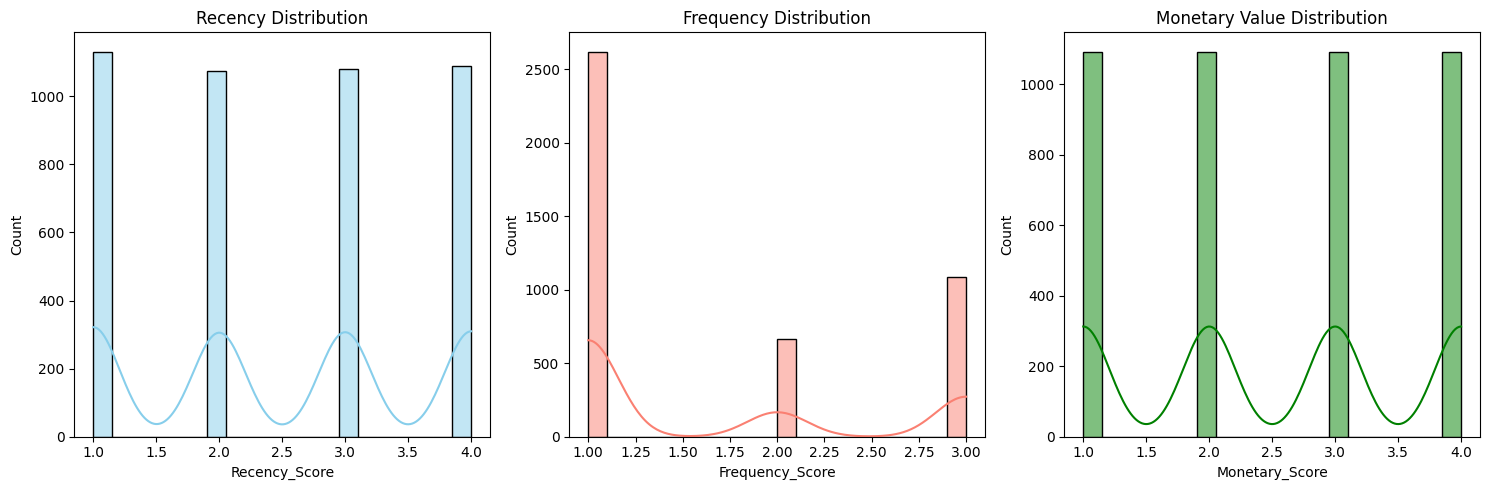

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming rfm_df is your DataFrame with RFM scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency_Score'], bins=20, kde=True, color='skyblue')
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency_Score'], bins=20, kde=True, color='salmon')
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary_Score'], bins=20, kde=True, color='green')
plt.title('Monetary Value Distribution')

plt.tight_layout()
plt.show()


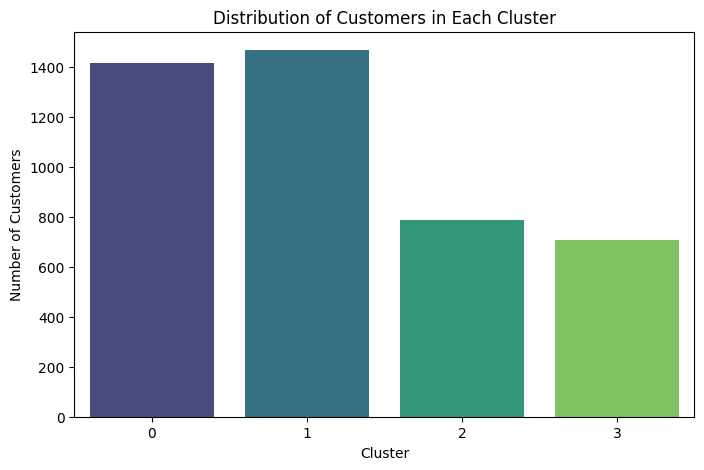

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=rfm_df, palette='viridis')
plt.title('Distribution of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()



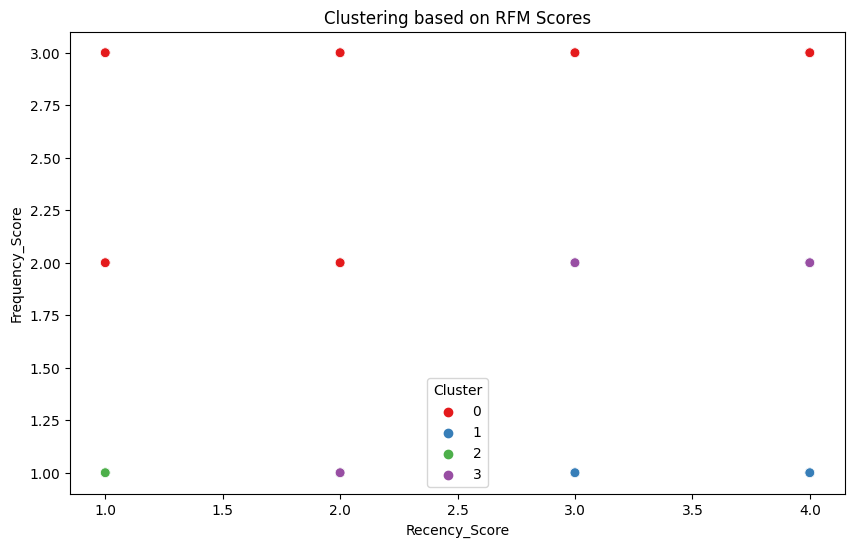

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency_Score', y='Frequency_Score', hue='Cluster', data=rfm_df, palette='Set1', s=50)
plt.title('Clustering based on RFM Scores')
plt.show()

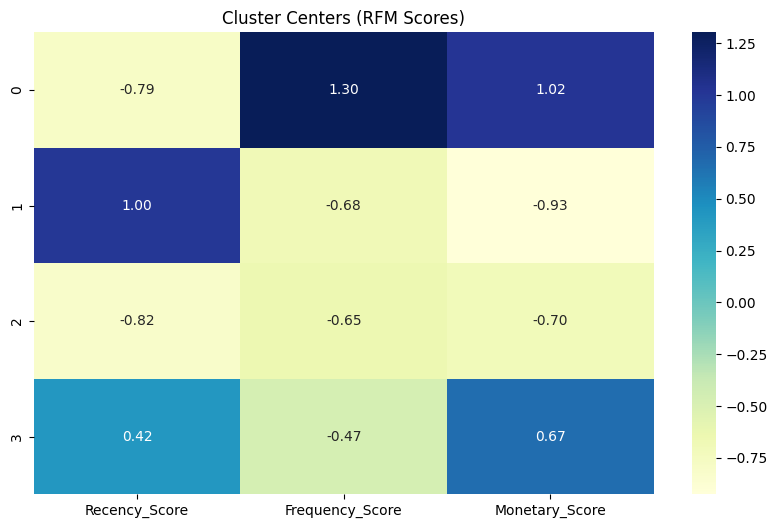

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centers, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=['Recency_Score', 'Frequency_Score', 'Monetary_Score'])
plt.title('Cluster Centers (RFM Scores)')
plt.show()

#Q1
1.1)What is the size of the dataset in terms of the number of rows and columns?

ANS-The dataset contains 4372 rows and 8 columns.

1.2)Can you provide a brief description of each column in the dataset?

**Description** of each column:
InvoiceNo: Invoice number for each transaction.
StockCode: Code identifying the product.
Description: Description of the product.
Quantity: Quantity of the product purchased.
InvoiceDate: Date and time of the transaction.
UnitPrice: Price per unit of the product.
CustomerID: ID of the customer.
Country: Country where the transaction took place.


In [ ]:
#1.3 What is the time period covered by this dataset?

# Find the earliest and latest dates
earliest_date = df['InvoiceDate'].min()
latest_date = df['InvoiceDate'].max()

# Calculate the time period
time_period = latest_date - earliest_date

# Display the time period
print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)
print("Time Period Covered:", time_period)

Earliest Date: 2010-12-01 08:26:00
Latest Date: 2011-12-09 12:50:00
Time Period Covered: 373 days 04:24:00


## Customer Analysis

### **Unique Customers**

In [ ]:
#2.1 how many unique cx are there?

unique_customers = df['CustomerID'].nunique()
print("Number of unique customers:", unique_customers)


Number of unique customers: 4372


### Number of Orders per customers

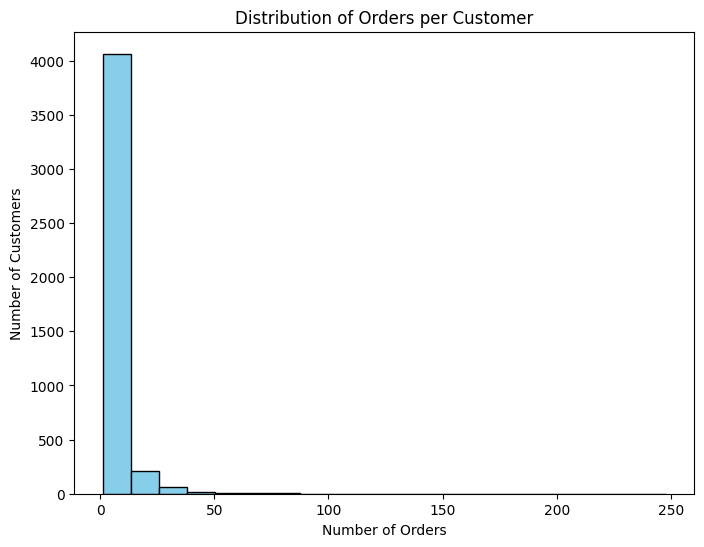

In [ ]:
#2.2 What is the distribution of the number of orders per customer?
# Group orders by 'CustomerID' and count the number of unique orders per customer
orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Visualize the distribution of orders per customer
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(orders_per_customer, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.title('Distribution of Orders per Customer')
plt.show()


### Top 5 customers

In [ ]:
#2.3
# Group orders by 'CustomerID' and count the number of unique orders per customer
orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Sort customers by the number of orders in descending order
top_customers = orders_per_customer.sort_values(ascending=False).head(5)

# Display the top 5 customers with the most purchases by order count
print("Top 5 Customers with the Most Purchases by Order Count:")
print(top_customers)


Top 5 Customers with the Most Purchases by Order Count:
CustomerID
14911.0    248
12748.0    224
17841.0    169
14606.0    128
13089.0    118
Name: InvoiceNo, dtype: int64


## **Product Analysis**

### Top 10 most frequently purchased products

In [ ]:
#3.1What are the top 10 most frequently purchased products?
# Group products by 'StockCode' and sum the quantity to get total purchases
frequent_products = df.groupby('Description')['Quantity'].sum()

# Sort products by total quantity purchased in descending order
top_10_products = frequent_products.sort_values(ascending=False).head(10)

# Create a DataFrame with StockCode and corresponding quantities
top_10_products_df = pd.DataFrame({'StockCode': top_10_products.index, 'TotalQuantity': top_10_products.values})

# Display the top 10 most frequently purchased products with quantities
print("Top 10 Most Frequently Purchased Products:")
print(top_10_products_df)



Top 10 Most Frequently Purchased Products:
                            StockCode  TotalQuantity
0   WORLD WAR 2 GLIDERS ASSTD DESIGNS          53215
1             JUMBO BAG RED RETROSPOT          45066
2       ASSORTED COLOUR BIRD ORNAMENT          35314
3  WHITE HANGING HEART T-LIGHT HOLDER          34147
4     PACK OF 72 RETROSPOT CAKE CASES          33409
5                      POPCORN HOLDER          30504
6                  RABBIT NIGHT LIGHT          27094
7             MINI PAINT SET VINTAGE           25880
8          PACK OF 12 LONDON TISSUES           25321
9  PACK OF 60 PINK PAISLEY CAKE CASES          24163


### 3.2 average price of products

In [ ]:
#3.2 What is the average price of products in the dataset?
# Calculate the average price of products in the dataset
average_price = df['UnitPrice'].mean()

# Display the average price
print("Average price of products:", average_price)


Average price of products: 3.460471018536043


### 3.3 Product category generates the highest revenue

In [ ]:
#3.3 Can you find out which product category generates the highest revenue?

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Grouping by product category (Description or StockCode) to find total revenue
category_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)
print(category_revenue.head(1))  # Displaying the category generating the highest revenue




Description
REGENCY CAKESTAND 3 TIER    132870.4
Name: TotalPrice, dtype: float64


<ipython-input-25-2eb9868c2e0a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


## Customer Segmentation

### 4.1 Is there a specific day of the week or time of day when most orders are placed?

<ipython-input-26-163c98f790ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
<ipython-input-26-163c98f790ee>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HourOfDay'] = df['InvoiceDate'].dt.hour


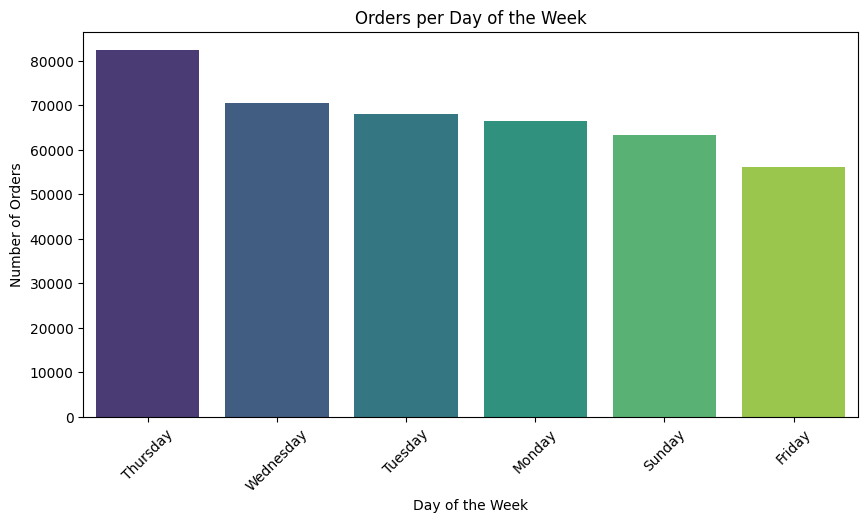

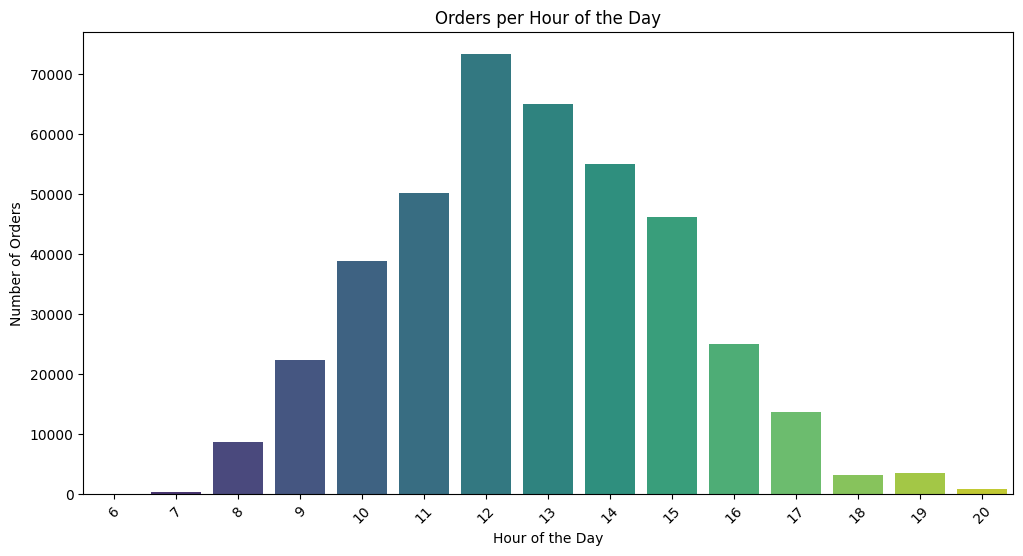

In [ ]:
#4.1 Is there a specific day of the week or time of day when most orders are placed?

# Extract day of the week and hour
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['HourOfDay'] = df['InvoiceDate'].dt.hour

# Count of orders per day of the week
orders_per_day = df['DayOfWeek'].value_counts()

# Count of orders per hour of the day
orders_per_hour = df['HourOfDay'].value_counts()

# Plotting the orders per day of the week
plt.figure(figsize=(10, 5))
sns.barplot(x=orders_per_day.index, y=orders_per_day.values, palette='viridis')
plt.title('Orders per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

# Plotting the orders per hour of the day
plt.figure(figsize=(12, 6))
sns.barplot(x=orders_per_hour.index, y=orders_per_hour.values, palette='viridis')
plt.title('Orders per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


### **4.2 What is the average order processing time?**

In [ ]:
#4.2
# Extracting month from 'InvoiceDate'
df['Month'] = df['InvoiceDate'].dt.month

# Grouping by month to analyze seasonal trends
monthly_sales = df.groupby('Month')['TotalPrice'].sum()
print(monthly_sales)
# Visualize this data to identify any seasonal patterns
# For example, using a line plot or bar chart to see sales variations across months.


Month
1      475074.380
2      436546.150
3      579964.610
4      426047.851
5      648251.080
6      608013.160
7      574238.481
8      616368.000
9      931440.372
10     974603.590
11    1132407.740
12     897110.400
Name: TotalPrice, dtype: float64


<ipython-input-28-374970ff3b40>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['InvoiceDate'].dt.month


### **4.3 Seasonal Trends**

<ipython-input-27-53d103bf04ff>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['InvoiceDate'].dt.month
<ipython-input-27-53d103bf04ff>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = df['Month'].map(seasons)


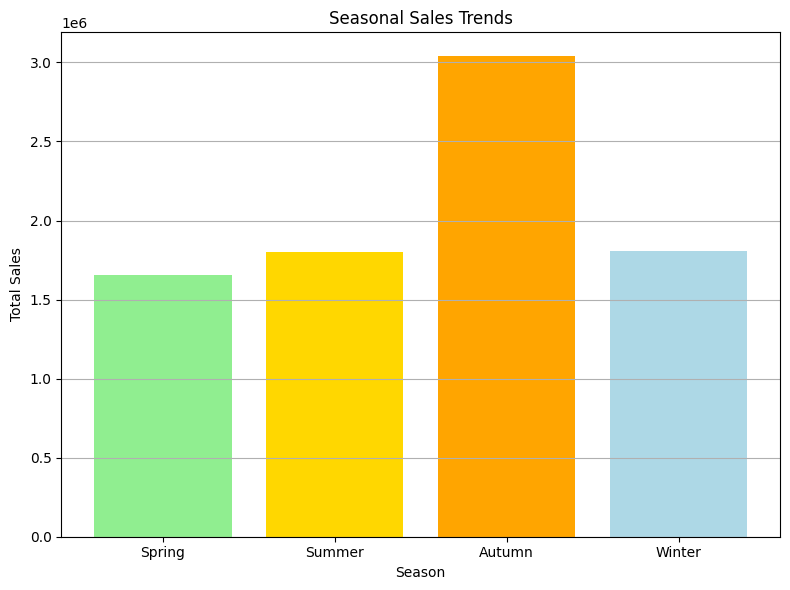

In [ ]:
#4.3
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' contains your dataset with 'InvoiceDate' and 'TotalPrice' columns

# Extracting month from 'InvoiceDate'
df['Month'] = df['InvoiceDate'].dt.month

# Mapping months to seasons
seasons = {
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Spring', 6: 'Summer',
    7: 'Summer', 8: 'Summer', 9: 'Autumn',
    10: 'Autumn', 11: 'Autumn', 12: 'Winter'
}

# Assigning seasons based on months
df['Season'] = df['Month'].map(seasons)

# Grouping by season to analyze seasonal trends
seasonal_sales = df.groupby('Season')['TotalPrice'].sum()

# Plotting the seasonal trends using a bar chart
plt.figure(figsize=(8, 6))
seasonal_sales = seasonal_sales.reindex(['Spring', 'Summer', 'Autumn', 'Winter'])  # Reordering seasons
plt.bar(seasonal_sales.index, seasonal_sales.values, color=['lightgreen', 'gold', 'orange', 'lightblue'])
plt.title('Seasonal Sales Trends')
plt.xlabel('Season')
plt.ylabel('Total Sales')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



## **5. Segment Profiling**


In [ ]:
#5
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd

# Assuming df is your DataFrame containing the order information

# Create a new column for the total order value
df['TotalOrderValue'] = df['Quantity'] * df['UnitPrice']

# Grouping by country to find the total order value for each country
country_order_values = df.groupby('Country')['TotalOrderValue'].sum()

# Calculate the total number of orders per country
orders_per_country = df.groupby('Country')['InvoiceNo'].nunique()

# Calculate the average order value per country
average_order_value = country_order_values / orders_per_country

# Display the top 5 countries with the highest number of orders
top_countries_by_orders = orders_per_country.sort_values(ascending=False).head(5)
print("Top 5 countries with the highest number of orders:")
print(top_countries_by_orders)

# Display the average order value for each country
print("\nAverage order value for each country:")
print(average_order_value)

# Calculate the correlation between the number of orders and average order value
correlation = top_countries_by_orders.corr(average_order_value[top_countries_by_orders.index])
print(f"\nCorrelation between the number of orders and average order value: {correlation}")

Top 5 countries with the highest number of orders:
Country
United Kingdom    19857
Germany             603
France              458
EIRE                319
Belgium             119
Name: InvoiceNo, dtype: int64

Average order value for each country:
Country
Australia               1986.627101
Austria                  534.437895
Bahrain                  274.200000
Belgium                  343.789580
Brazil                  1143.600000
Canada                   611.063333
Channel Islands          608.675455
Cyprus                   647.314500
Czech Republic           141.544000
Denmark                  893.720952
EIRE                     784.593166
European Community       258.350000
Finland                  465.140417
France                   429.504017
Germany                  367.658723
Greece                   785.086667
Iceland                  615.714286
Israel                  1165.708333
Italy                    307.100182
Japan                   1262.165000
Lebanon                 

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

## **Customer Behaviour**

### **7.a Average Customer Active Time analysis**

Average duration of customer activity: 133.38586459286367


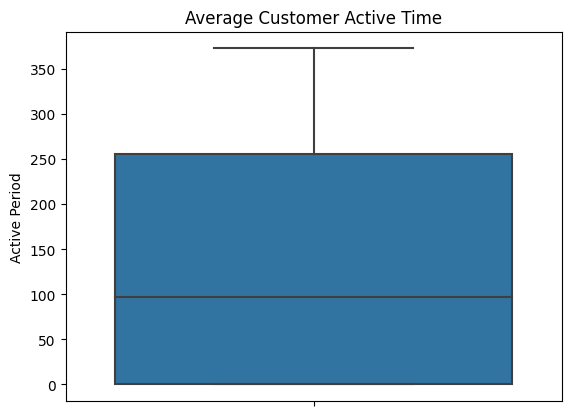

In [16]:
#7.1
customer_activity_duration = df.groupby('CustomerID')['InvoiceDate'].apply(lambda x: x.max() - x.min()).reset_index()
customer_activity_duration.columns=["CustomerID","Active Period"]
customer_activity_duration["Active Period"] = customer_activity_duration["Active Period"].dt.days
average_duration = customer_activity_duration["Active Period"].mean()
print(f"Average duration of customer activity: {average_duration}")
sns.boxplot(data=customer_activity_duration,y="Active Period")
plt.title("Average Customer Active Time")
plt.show()

### **7a. Customer Segments distribution**

In [20]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
customer_activity = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])

#average duration of customer activity
customer_activity['ActivityDuration'] = (customer_activity['max'] - customer_activity['min']).dt.days.mean()

print(f'Average Duration of Customer Activity: {customer_activity["ActivityDuration"].mean()} days')

#recency and frequency
recency = (customer_activity['max'].max() - customer_activity['max']).dt.days
frequency = df['CustomerID'].value_counts()
customer_segments = pd.DataFrame({'Recency': recency, 'Frequency': frequency})

# segment thresholds
recency_threshold = customer_segments['Recency'].median()
frequency_threshold = customer_segments['Frequency'].median()

# Assign segments
customer_segments['Segment'] = 'Low Activity'
customer_segments.loc[(customer_segments['Recency'] <= recency_threshold) & (customer_segments['Frequency'] > frequency_threshold), 'Segment'] = 'High Activity'

print('Customer Segments:')
customer_segments.head(10)

Average Duration of Customer Activity: 133.38586459286367 days
Customer Segments:


<ipython-input-20-0ccd8fbbf1fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


,Recency,Frequency,Segment
12346.0,325,2,Low Activity
12347.0,1,182,High Activity
12348.0,74,31,Low Activity
12349.0,18,73,High Activity
12350.0,309,17,Low Activity
12352.0,35,95,High Activity
12353.0,203,4,Low Activity
12354.0,231,58,Low Activity
12355.0,213,13,Low Activity
12356.0,22,59,High Activity
